In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from utils import data_path, get_rmse, plot_diff

# Load data

In [2]:
simus = ['ssp126',
         'ssp370',
         'ssp585']

In [3]:
len_historical = 165

In [4]:
X_train = []
Y_train = []

for i, simu in enumerate(simus):

    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'

    # load inputs 
    input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc', 
                                data_path + input_name]).compute()
        
    # load outputs                                                             
    output_xr = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim='member'),
                            xr.open_dataset(data_path + output_name).mean(dim='member')],
                            dim='time').compute()
    output_xr = output_xr.assign({"pr": output_xr.pr * 86400,
                                    "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                                                                            'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])

    print(input_xr.dims, simu)

    # Append to list 
    X_train.append(input_xr)
    Y_train.append(output_xr)

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585


# Data normalization

In [5]:
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return (data - mean)/std

def unnormalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return data * std + mean

In [6]:
meanstd_inputs = X_train[-1].mean(), X_train[-1].std()

In [8]:
# normalize input data 
X_train_norm = [] 
for i, train_xr in enumerate(X_train): 
    for var in ['CO2', 'CH4', 'SO2', 'BC']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))}) 
    X_train_norm.append(train_xr)

## Reshape data to feed into the model 

In [9]:
slider = 10 # years moving temporal window 

In [10]:
def sliding_window_X(X_train_np, len_historical=None):
    time_length = X_train_np.shape[0]
    
    Y_train_to_return = np.array([X_train_np[i:i+slider] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

def sliding_window_Y(Y_train_np, len_historical=None):
    time_length = Y_train_np.shape[0]
    
    Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

# CNN - LSTM architecture
## Build model

In [11]:
var_to_predict =  'tas'
X_train_all = np.concatenate([sliding_window_X(_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical) for _train in X_train_norm], axis = 0)
Y_train_all = np.concatenate([sliding_window_Y(_train['tas'], len_historical=len_historical) for _train in Y_train], axis=0)
print(X_train_all.shape)
print(Y_train_all.shape)

(258, 10, 96, 144, 4)
(258, 1, 96, 144)


Inspiration: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

import random 
seed = 6 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
keras.backend.clear_session()
cnn_model = None

In [14]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='tanh'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))


In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 96, 144, 20)   740       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 48, 72, 20)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 20)            0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 13824)             359424    
                                                        

In [16]:
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

# Train model

In [17]:
X_train_all.shape, Y_train_all.shape

((258, 10, 96, 144, 4), (258, 1, 96, 144))

In [18]:
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

Epoch 1/30
17/17 [==============================] - 1s 27ms/step - loss: 7.9538 - mse: 7.9538
Epoch 2/30
17/17 [==============================] - 0s 20ms/step - loss: 6.9660 - mse: 6.9660
Epoch 3/30
17/17 [==============================] - 0s 20ms/step - loss: 5.2011 - mse: 5.2011
Epoch 4/30
17/17 [==============================] - 0s 20ms/step - loss: 3.8019 - mse: 3.8019
Epoch 5/30
17/17 [==============================] - 0s 20ms/step - loss: 3.0206 - mse: 3.0206
Epoch 6/30
17/17 [==============================] - 0s 21ms/step - loss: 2.6025 - mse: 2.6025
Epoch 7/30
17/17 [==============================] - 0s 20ms/step - loss: 2.3042 - mse: 2.3042
Epoch 8/30
17/17 [==============================] - 0s 21ms/step - loss: 2.0982 - mse: 2.0982
Epoch 9/30
17/17 [==============================] - 0s 20ms/step - loss: 1.9357 - mse: 1.9357
Epoch 10/30
17/17 [==============================] - 0s 20ms/step - loss: 1.8060 - mse: 1.8060
Epoch 11/30
17/17 [==============================] - 0s 20m

# Make final prediction for submission

In [19]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = sliding_window_X(X_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical)  

In [32]:
# Make predictions using trained model 
m_pred = cnn_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], 
                      coords=[X_test.time.data[len_historical:], 
                              X_test.latitude.data, 
                              X_test.longitude.data]).sel(time=slice(2015, 2101))
m_pred

3/3 [==============================] - 0s 24ms/step


<xarray.DataArray (time: 86, lat: 96, lon: 144)>
array([[[1.1933177, 1.1994557, 1.2020682, ..., 1.2072417, 1.1987703,
         1.1929556],
        [1.2664074, 1.2780187, 1.2675579, ..., 1.2621113, 1.2784646,
         1.2679573],
        [1.2432543, 1.2459807, 1.2631019, ..., 1.2424542, 1.2180225,
         1.2429235],
        ...,
        [2.966704 , 2.9465091, 2.9553785, ..., 2.9822855, 2.9640775,
         2.9763079],
        [3.0296338, 3.0267806, 3.0351763, ..., 3.0460887, 3.0357916,
         3.0185041],
        [3.1019998, 3.08661  , 3.0838757, ..., 3.0786602, 3.077356 ,
         3.096588 ]],

       [[1.2033467, 1.2096695, 1.2117434, ..., 1.2171432, 1.2086045,
         1.202786 ],
        [1.2764943, 1.2882481, 1.2779231, ..., 1.2723366, 1.2887418,
         1.2783791],
        [1.2532549, 1.2562385, 1.2732528, ..., 1.2525215, 1.2275947,
         1.2528744],
...
        [6.0361724, 6.0332823, 6.0421166, ..., 6.110794 , 6.0845857,
         6.0903435],
        [6.1936965, 6.1401873, 6.180943 , ..., 6.200704 , 6.2173395,
         6.204583 ],
        [6.303151 , 6.325973 , 6.296545 , ..., 6.286745 , 6.2813334,
         6.3125076]],

       [[2.6408198, 2.658251 , 2.6511333, ..., 2.6435502, 2.6465168,
         2.6581142],
        [2.8616807, 2.8481443, 2.8595207, ..., 2.8549159, 2.8492873,
         2.8409657],
        [2.831308 , 2.8354218, 2.8467164, ..., 2.7495074, 2.8024235,
         2.8217905],
        ...,
        [6.046558 , 6.043821 , 6.052595 , ..., 6.1215353, 6.0954347,
         6.10087  ],
        [6.204435 , 6.150926 , 6.1918116, ..., 6.2115736, 6.2280755,
         6.215552 ],
        [6.3141594, 6.33708  , 6.3075514, ..., 6.2976837, 6.2923656,
         6.3234797]]], dtype=float32)
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [33]:
tas_truth = xr.open_mfdataset([data_path + 'outputs_ssp245.nc'])['tas'].mean('member').compute()

In [34]:
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], m_pred[65:].data).mean()}")


RMSE 2090-2100: 0.3859914623146643


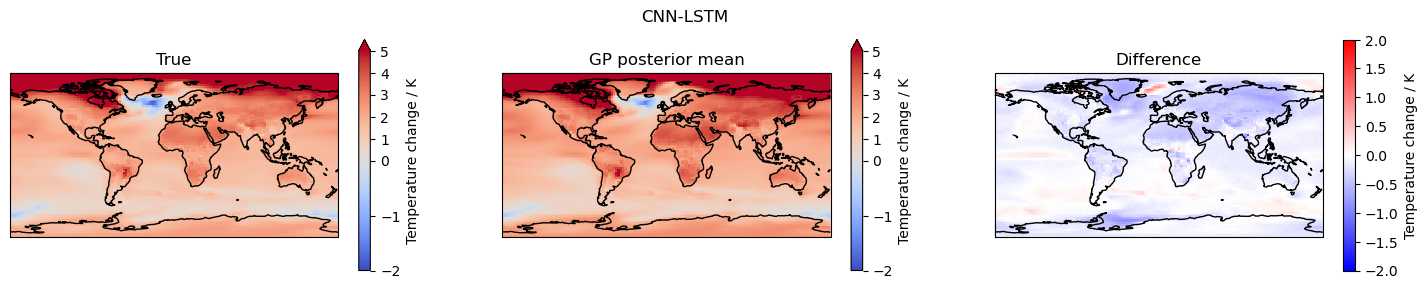

In [35]:
plot_diff(tas_truth, m_pred, 'CNN-LSTM')